In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [4]:
import scanpy as sc
# import scvelo as scv

# read the full GSE dataset
# data = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/Hao_PBMC_GSE164378.h5ad')
data = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\GSE164378\Hao_PBMC_GSE164378.h5ad")
data.shape

(161764, 33538)

In [ ]:
### Raw counts were not normalizaed
# CPM
sc.pp.normalize_total(data, target_sum=1e6)

# log1p
sc.pp.log1p(data)

In [5]:
data.obs['celltype.l2'] = data.obs['celltype.l2'].str.replace(' ', '_')

label = data.obs['celltype.l2'].tolist()
types = np.unique(label).tolist()
# types = [s.replace(' ', '_') for s in types]
print(types)

['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']


## Read features

In [ ]:
# Level 1 ADlasso features by loss difference convergence
import os
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L2_by_lossdiff\feature_selection")

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    # print(celltype, 'Feature count:', feature_df.shape[0])
    # print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    # print('------------------')

In [ ]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

## Get likelihood from LR model

In [ ]:
def LR_likelihood(data, all_features_dict, celltype):
    print('====================')
    print('Celltype:', celltype)
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l2'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    decision_scores = clf.decision_function(X)  # >0: predict celltype, <0: predict not celltype
    print('decision_scores > 0:', sum(decision_scores > 0))

    # calculate the likelihood of the positive class for each observation in X based on the decision scores
    likelihood = 1 / (1 + np.exp(-decision_scores))
    print('likelihood > 0.5:', sum(likelihood > 0.5))  # >0.5: predict celltype, <0.5: predict not celltype

    return likelihood


In [ ]:
celltype = 'B_memory'
Bm_likelihood = LR_likelihood(data, features_dict, celltype)
Bm_likelihood.shape

In [ ]:
sum(data.obs['celltype.l2'] == celltype)

In [ ]:
likelihood_dict = {}
for celltype in types:
    likelihood_dict[celltype] = LR_likelihood(data, features_dict, celltype)

In [ ]:
# turn likelihood_dict into dataframe
likelihood_df = pd.DataFrame(likelihood_dict)
likelihood_df.insert(0, "Original index", likelihood_df.index)
likelihood_df.head()

In [ ]:
likelihood_df.shape

In [ ]:
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L2_by_lossdiff\LR_likelihood")

likelihood_df.to_csv('L2_likelihood_df.csv', index=False)

In [9]:
# read likelihood_df
likelihood_df = pd.read_csv('L2_likelihood_df.csv')
likelihood_df.head()

,ASDC,B_intermediate,B_memory,B_naive,CD14_Mono,CD16_Mono,CD4_CTL,CD4_Naive,CD4_Proliferating,CD4_TCM,...,NK_CD56bright,NK_Proliferating,Plasmablast,Platelet,Treg,cDC1,cDC2,dnT,gdT,pDC
0,0.000152,5.708611e-07,1.925501e-05,6.643769e-06,9.654989e-01,7.956638e-05,4.816041e-09,3.122806e-08,8.444218e-06,0.000169,...,8.782559e-10,1.252195e-05,9.107458e-10,0.000168,0.002260,3.068905e-11,3.970579e-06,6.319588e-05,8.966452e-07,6.964113e-14
1,0.000286,1.111099e-06,5.090013e-06,3.721794e-09,1.851954e-14,7.844752e-13,1.085429e-06,9.007209e-02,1.899941e-08,0.936903,...,1.667237e-07,1.186647e-10,5.376698e-10,0.000149,0.050373,1.015479e-09,2.365609e-13,1.558057e-04,4.017738e-04,9.901633e-14
2,0.000200,1.038272e-06,6.014920e-07,1.241759e-05,1.504912e-16,3.533338e-13,1.344869e-07,1.040311e-02,6.835560e-15,0.000014,...,4.518712e-08,3.136866e-10,9.316321e-10,0.000077,0.032858,3.820480e-10,9.480921e-14,1.320075e-04,1.680838e-03,1.382401e-13
3,0.000252,1.744693e-06,1.396504e-08,8.355292e-10,3.085746e-11,8.639402e-07,4.670319e-06,1.909425e-06,7.772327e-13,0.000001,...,1.046097e-04,2.532274e-06,1.009118e-09,0.000195,0.010205,6.470233e-11,1.116833e-13,5.464972e-07,2.852407e-02,3.580897e-11
4,0.000243,1.332987e-06,3.972125e-06,2.246356e-08,1.822862e-11,3.820293e-09,5.151212e-08,8.228114e-03,1.703282e-12,0.000400,...,3.437187e-07,7.780025e-10,1.805342e-09,0.000127,0.045294,6.771880e-12,4.269626e-12,1.254787e-03,9.754249e-04,1.199447e-13


## (1st_type / 2nd_type) >= 1.5

In [12]:
# test = likelihood_df.head(1500)
largest_values = []
second_largest_values = []
largest_columns = []
second_largest_columns = []
odds_ratio_list = []
assignments = []

for index, row in likelihood_df.iterrows():
    # find 1st and 2nd largest values and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    second_largest_value = row.nlargest(2).iloc[-1]
    second_largest_column = row.nlargest(2).index[-1]
    
    largest_values.append(largest_value)
    second_largest_values.append(second_largest_value)
    largest_columns.append(largest_column)
    second_largest_columns.append(second_largest_column)

    # calculate odds ratio
    odds_ratio = largest_value / second_largest_value
    if odds_ratio >= 1.5:
        assign = largest_column
    else:
        assign = 'Uncertain'
    odds_ratio_list.append(odds_ratio)
    assignments.append(assign)

result_df = pd.DataFrame({'Largest Value': largest_values, 'Largest Column': largest_columns,
                          'Second Largest Value': second_largest_values, 'Second Largest Column': second_largest_columns, 
                          'Odds Ratio': odds_ratio_list, 'Assignment': assignments})
result_df.shape


(161764, 6)

In [13]:
result_df.head(20)

,Largest Value,Largest Column,Second Largest Value,Second Largest Column,Odds Ratio,Assignment
0,0.965499,CD14_Mono,0.002260,Treg,427.167529,CD14_Mono
1,0.936903,CD4_TCM,0.090072,CD4_Naive,10.401700,CD4_TCM
2,0.991711,CD8_Naive,0.039888,CD8_TEM,24.862561,CD8_Naive
3,0.986527,NK,0.028524,gdT,34.585759,NK
4,0.507807,CD8_Naive,0.050004,CD8_TCM,10.155431,CD8_Naive
5,0.947369,CD8_TEM,0.021912,Treg,43.235988,CD8_TEM
6,0.698266,CD14_Mono,0.040876,CD16_Mono,17.082514,CD14_Mono
7,0.750882,B_intermediate,0.197165,B_memory,3.808404,B_intermediate
8,0.994369,NK,0.012758,Treg,77.940798,NK
9,0.964652,CD8_Naive,0.140333,Treg,6.874022,CD8_Naive


In [14]:
sum(result_df['Assignment'] == 'Uncertain')

11448

In [15]:
11448/len(result_df)

0.07076976335896738

## Confusion heatmap

In [36]:
import pandas as pd

# Get the true labels
true_labels = data.obs['celltype.l2'].tolist()

# Get the predicted labels
predicted_labels = result_df['Assignment'].tolist()

# Create the confusion matrix
cm = pd.crosstab(true_labels, predicted_labels, rownames=['True'], colnames=['Predicted'], margins=False)

# reorder columns
cm = cm.reindex(types + ['Uncertain'], axis=1)

cm = cm.fillna(0)
cm = cm.astype(int)


In [37]:
cm.shape

(31, 32)

In [2]:
cm = pd.read_csv('L2_LR_confusion_matrix.csv', index_col=0)
cm

,ASDC,B_intermediate,B_memory,B_naive,CD14_Mono,CD16_Mono,CD4_CTL,CD4_Naive,CD4_Proliferating,CD4_TCM,...,NK_Proliferating,Plasmablast,Platelet,Treg,cDC1,cDC2,dnT,gdT,pDC,Uncertain
True,,,,,,,,,,,,,,,,,,,,,
ASDC,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,47,0,0,20,6
B_intermediate,0,1425,173,352,0,0,0,0,0,4,...,0,0,0,3,0,0,0,0,0,466
B_memory,0,114,2918,20,0,1,0,0,0,2,...,0,2,0,1,0,0,0,2,0,223
B_naive,0,79,27,7352,0,4,0,0,0,1,...,0,0,0,4,0,0,0,0,0,245
CD14_Mono,4,0,0,1,42181,129,1,4,0,2,...,0,2,16,15,0,22,0,0,0,293
CD16_Mono,0,0,1,0,238,5717,0,0,0,0,...,0,0,0,0,0,3,0,0,0,358
CD4_CTL,0,0,0,0,0,0,1442,0,0,4,...,0,0,0,1,0,0,0,2,0,185
CD4_Naive,0,0,0,0,0,0,0,16336,0,309,...,0,0,0,29,0,0,4,10,0,745
CD4_Proliferating,0,0,0,0,1,0,0,0,63,1,...,0,0,0,1,0,0,0,0,0,42


In [38]:
# export confusion matrix
# cm.to_csv('L2_LR_confusion_matrix.csv')

## Calculate accuracy

In [5]:
# diagonal sum of confusion matrix
accuracy = sum(np.diag(cm)) / cm.values.sum()
accuracy

0.8671026928117505

In [6]:
# sum of confusion matrix
cm.values.sum()

161764

## Plot heatmap

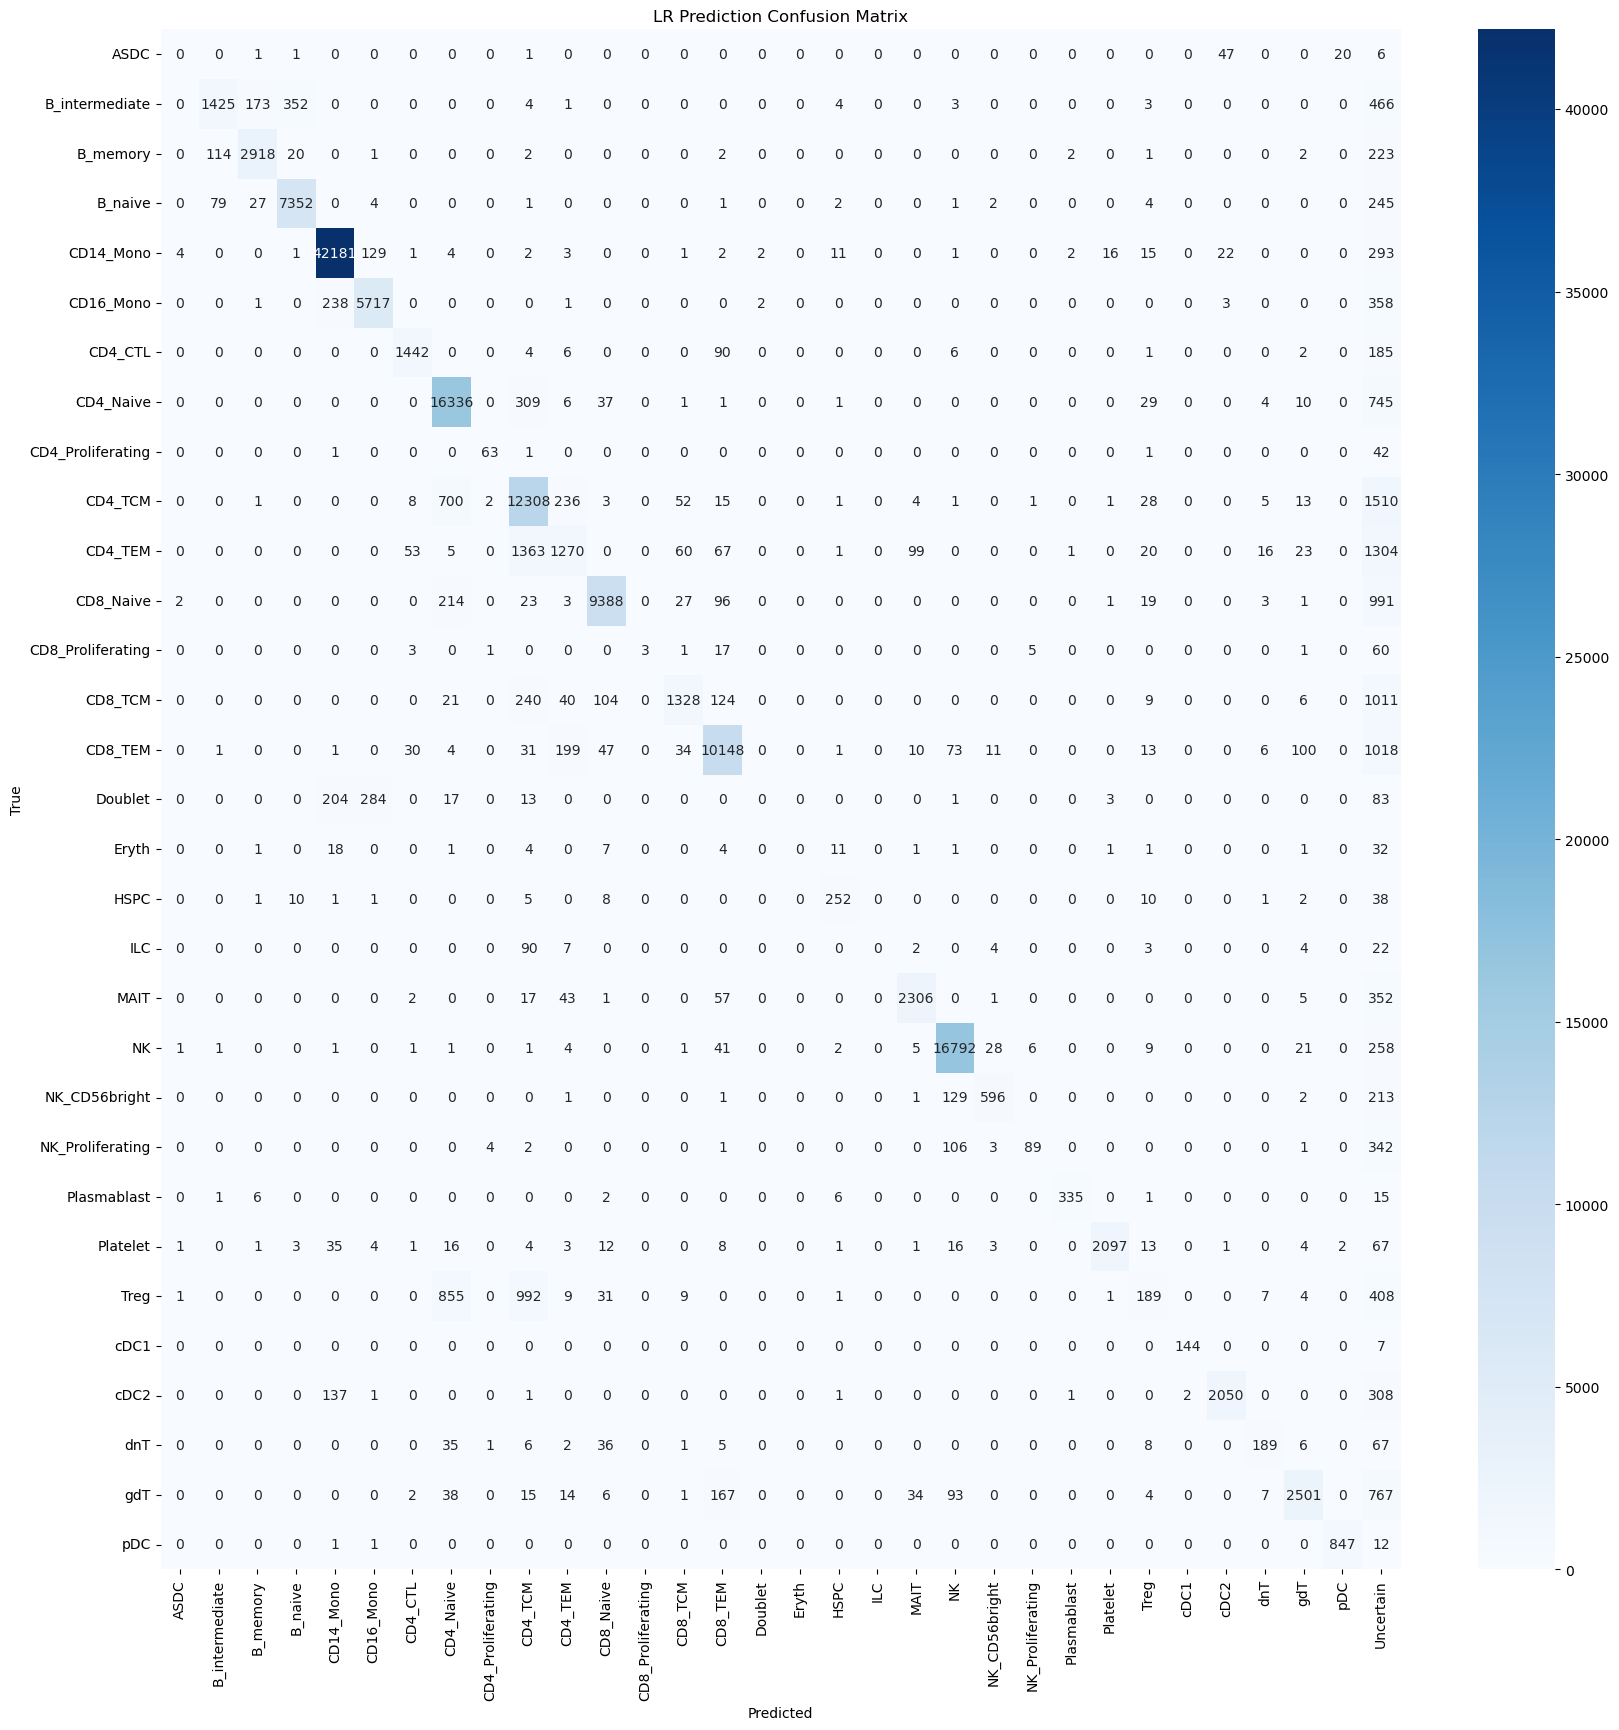

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LR Prediction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [5]:
row_sum = cm.sum(axis=1)


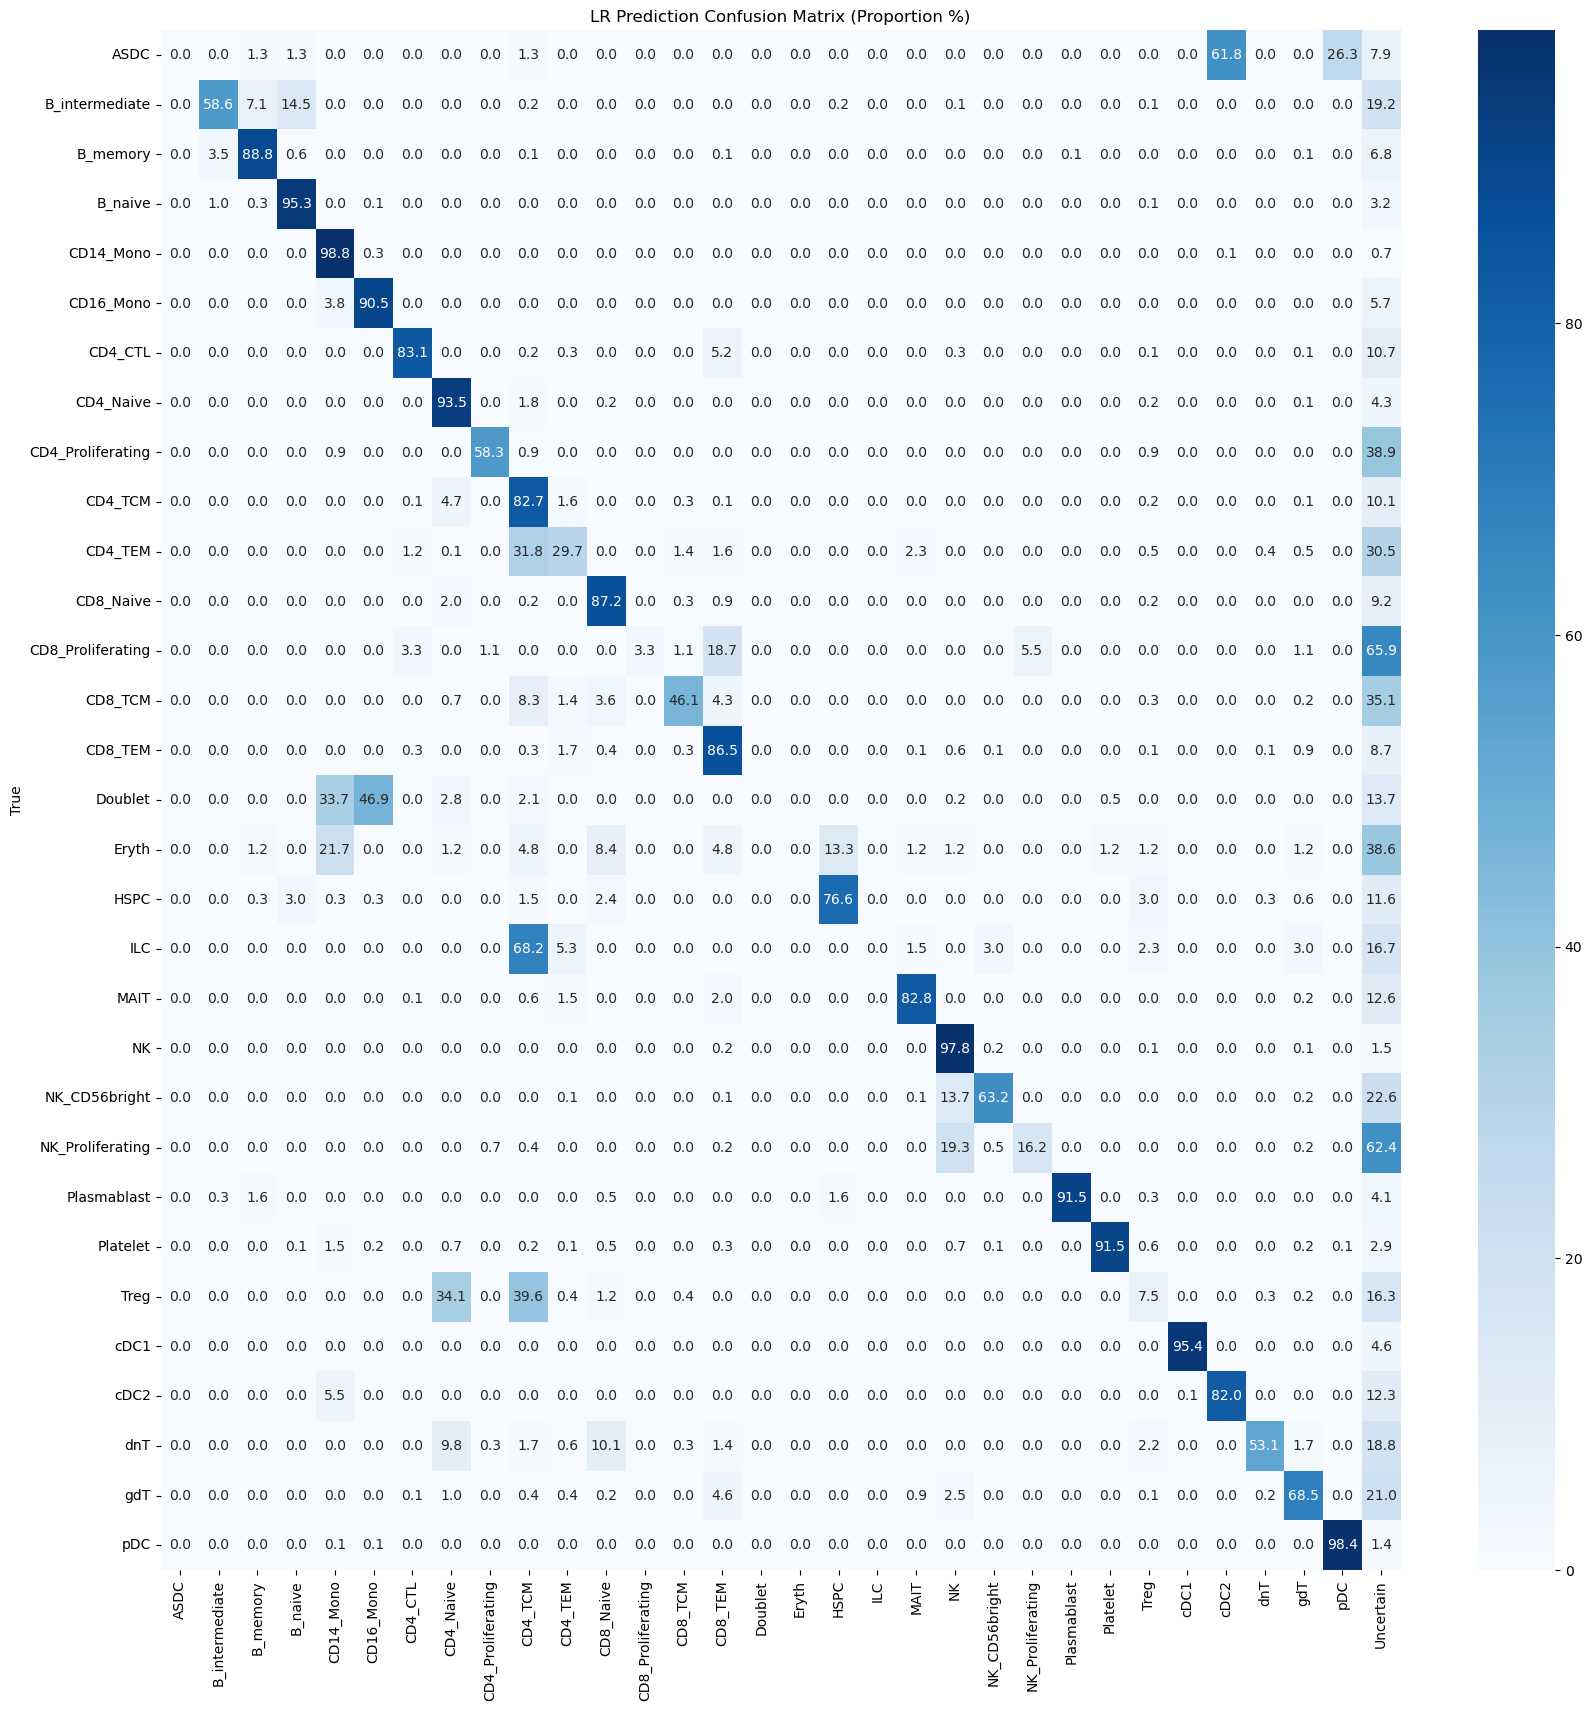

In [8]:
cm_proportion = cm.div(row_sum, axis=0)
cm_proportion *= 100
plt.figure(figsize=(20, 20))
sns.heatmap(cm_proportion, fmt=".1f", annot=True, cmap='Blues')
plt.title('LR Prediction Confusion Matrix (Proportion %)')
plt.show()